Here, we redefine the aimc value based on the original Park & Choi (2005) definition of the early type galaxies in the color - color-gradient space:

\begin{equation}
  \text{aimc} = \tan^{-1} \left( \frac{-\Delta (g-i) + 0.3}{(u-r) - 1} \right) + 90^\circ
\end{equation}

In [1]:
from astropy.table import Table, vstack

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Data import

In [2]:
#galaxy_filename = '/Users/kellydouglass/Documents/Drexel/Research/Data/kias1033_5_P-MJD-F_MPAJHU_ZdustOS_stellarMass_BPT_SFR_NSA_correctVflag.txt'
galaxy_filename = '/Users/kellydouglass/Documents/Research/data/NSA_v1_0_1_VAGC.fits'

#galaxies = Table.read(galaxy_filename, format='ascii.commented_header')
galaxies = Table.read(galaxy_filename, format='fits')

# Calculate aimc

In [3]:
def my_aimc(grad, color):
    
    grad_shift = 0.3
    color_shift = -1
    
    aimc = np.arctan2(-grad + grad_shift, color + color_shift) + 0.5*np.pi
    
    # Need to convert from radians to degrees
    aimc = aimc*180/np.pi
    
    # Need to map [-180,0) to [180,360)
    aimc[aimc < 0] += 360
    
    return aimc

In [4]:
galaxies['my_aimc'] = my_aimc(galaxies['cd'], galaxies['u_r_KIAS'])

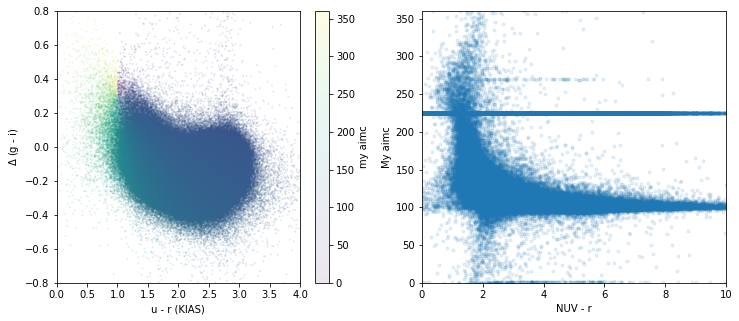

In [5]:
plt.figure(figsize=(12,5))



plt.subplot(121)

plt.scatter(galaxies['u_r_KIAS'], galaxies['cd'], s=1, c=galaxies['my_aimc'], alpha=0.1)

cbar = plt.colorbar()
cbar.ax.set_ylabel('my aimc')

plt.xlabel('u - r (KIAS)')
plt.ylabel('$\Delta$ (g - i)')

plt.axis([0, 4, -0.8, 0.8])



plt.subplot(122)

plt.plot(galaxies['NUV_r'], galaxies['my_aimc'], '.', alpha=0.1)

#plt.hlines([45, 275], 0, 10, colors='r', linestyle='dotted')

#plt.vlines(5, 0, 165, colors='g', linestyle='dashed')

plt.axis([0, 10, 0, 360])

plt.xlabel('NUV - r')
plt.ylabel('My aimc');

# Define the GV

Split the galaxies up based on their location in the color - color gradient space (based on Park & Choi 2005 and Choi et al. 2010), their inverse concentration index, and their my_aimc value.

- RS: normal early-type galaxies
- GV: 
      - blue early-type galaxies
      - normal late-type galaxies within the bounds of early-types with `conx1` > some value
      - normal late-type galaxies with `my_aimc` < 110
- BC: normal late-type galaxies with `my_aimc` > 110

#### Magnitude bins

In [6]:
boolean_14p5_16 = galaxies['prmag'] < 16
boolean_16_16p5 = np.logical_and(galaxies['prmag'] >= 16, galaxies['prmag'] < 16.5)
boolean_16p5_17 = np.logical_and(galaxies['prmag'] >= 16.5, galaxies['prmag'] < 17)
boolean_17_17p5 = galaxies['prmag'] >= 17

### Define the `conx1` limit as the intersection of the skew-normal distribution sum

\begin{equation}
  f(x; \alpha, \mu_\alpha, \sigma_\alpha, \xi_\alpha, \beta, \mu_\beta, \sigma_\beta, \xi_\beta) = \alpha \phi(z_\alpha) \Phi(\xi_\alpha z_\alpha) + \beta \phi(z_\beta) \Phi(\xi_\beta z_\beta)
\end{equation}

where $z = (x - \mu)/\sigma$, $\phi$ is the standard normal distribution, and $\Phi$ is the standard normal CDF.

In [8]:
from skewNorms_fit import skewNorms2, skewNorms2_fit, skewNorms2_diff

from scipy.stats import skewnorm

In [9]:
cinv_bins = np.arange(0.2, 0.6, 0.005)
cinv_centers = 0.5*(cinv_bins[1:] + cinv_bins[:-1])

color_boolean = np.logical_and(galaxies['u_r_KIAS'] > 2.5, galaxies['u_r_KIAS'] < 3.5)

##### Brightest galaxies

In [10]:
param_bounds = [[10., 3000.],  # a ......... skew normal 1 amplitude
                [0.25, 0.35],  # mu_a ...... skew normal 1 mean
                [0.01, 3.0],   # sigma_a ... skew normal 1 standard deviation
                [-30., 30.],   # skew_a .... skew normal 1 skew
                [1., 1000.],   # b ......... skew normal 2 amplitude
                [0.35, 0.5],   # mu_b ...... skew normal 2 mean
                [0.01, 3.0],   # sigma_b ... skew normal 2 standard deviation
                [-20., 20.]    # skew_b .... skew normal 2 skew
               ]

In [13]:
dist_bright,_ = np.histogram(galaxies['conx1'][boolean_14p5_16 & color_boolean], bins=cinv_bins)

bestfit = skewNorms2_fit(cinv_centers, dist_bright, param_bounds)

print(bestfit)

      fun: 325.4078855919776
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([-9.60654382e-04,  1.43700163e-02,  1.20894583e-01, -3.85966816e-03,
       -5.51381117e-04,  5.95889560e-01,  4.54497240e-01,  9.79980536e-03])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 2718
      nit: 195
     njev: 302
   status: 0
  success: True
        x: array([1.22589824e+02, 2.91599664e-01, 3.70826443e-02, 3.68704591e+00,
       6.14708741e+01, 3.61859571e-01, 6.40223672e-02, 8.80246142e-01])


##### $16 < m_r < 16.5$

In [14]:
param_bounds = [[10., 3000.],  # a ......... skew normal 1 amplitude
                [0.25, 0.35],  # mu_a ...... skew normal 1 mean
                [0.01, 3.0],   # sigma_a ... skew normal 1 standard deviation
                [-30., 30.],   # skew_a .... skew normal 1 skew
                [1., 1000.],   # b ......... skew normal 2 amplitude
                [0.35, 0.5],   # mu_b ...... skew normal 2 mean
                [0.01, 3.0],   # sigma_b ... skew normal 2 standard deviation
                [-20., 20.]    # skew_b .... skew normal 2 skew
               ]

In [15]:
dist_16_16p5,_ = np.histogram(galaxies['conx1'][boolean_16_16p5 & color_boolean], bins=cinv_bins)

bestfit_16_16p5 = skewNorms2_fit(cinv_centers, dist_16_16p5, param_bounds)

print(bestfit_16_16p5)

      fun: 316.4634410306409
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 5.74118891e-04,  4.75188245e-01,  1.63564664e+00, -1.09139365e-03,
        2.72848388e-04, -2.47229082e-01, -8.61643912e-01, -1.10901510e-02])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 2916
      nit: 236
     njev: 324
   status: 0
  success: True
        x: array([ 1.14329582e+02,  2.94392305e-01,  4.20601939e-02,  4.16488799e+00,
        4.17049918e+01,  3.97886757e-01,  5.06510673e-02, -3.22887040e-03])


$16.5 < m_r < 17$

In [16]:
param_bounds_16p5_17 = [[10., 3000.],  # a ......... skew normal 1 amplitude
                        [0.25, 0.35],  # mu_a ...... skew normal 1 mean
                        [0.01, 3.0],   # sigma_a ... skew normal 1 standard deviation
                        [-30., 30.],   # skew_a .... skew normal 1 skew
                        [1., 1000.],   # b ......... skew normal 2 amplitude
                        [0.35, 0.6],   # mu_b ...... skew normal 2 mean
                        [0.01, 3.0],   # sigma_b ... skew normal 2 standard deviation
                        [0., 20.]    # skew_b .... skew normal 2 skew
                       ]

In [17]:
dist_16p5_17,_ = np.histogram(galaxies['conx1'][boolean_16p5_17 & color_boolean], bins=cinv_bins)

bestfit_16p5_17 = skewNorms2_fit(cinv_centers, dist_16p5_17, param_bounds_16p5_17)

print(bestfit_16p5_17)

      fun: 303.8830324869607
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 9.94759041e-04,  4.03741751e-01,  4.82134510e+00, -1.63595360e-02,
        1.02318218e-03,  2.07597850e-01, -2.64526534e-01,  3.06386028e-03])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 1755
      nit: 130
     njev: 195
   status: 0
  success: True
        x: array([1.78397354e+02, 2.97940756e-01, 4.52587142e-02, 3.98841157e+00,
       6.65281119e+01, 3.94281867e-01, 5.04950596e-02, 2.48567590e-02])


##### Faint galaxies

In [18]:
param_bounds_faint = [[10., 3000.],  # a ......... skew normal 1 amplitude
                      [0.25, 0.4],   # mu_a ...... skew normal 1 mean
                      [0.01, 3.0],   # sigma_a ... skew normal 1 standard deviation
                      [-30., 30.],   # skew_a .... skew normal 1 skew
                      [1., 1000.],   # b ......... skew normal 2 amplitude
                      [0.35, 0.6],   # mu_b ...... skew normal 2 mean
                      [0.01, 3.0],   # sigma_b ... skew normal 2 standard deviation
                      [-20., 20.]    # skew_b .... skew normal 2 skew
                     ]

In [19]:
dist_faint,_ = np.histogram(galaxies['conx1'][boolean_17_17p5 & color_boolean], bins=cinv_bins)

bestfit_faint = skewNorms2_fit(cinv_centers, dist_faint, param_bounds_faint)

print(bestfit_faint)

      fun: 321.67696674197526
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00350724,  0.64541723,  0.15194246, -0.01067519, -0.00397904,
       -0.08310508,  0.20829702,  0.00180194])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 2970
      nit: 232
     njev: 330
   status: 0
  success: True
        x: array([ 4.32943488e+02,  3.05292633e-01,  5.66051567e-02,  3.71713647e+00,
        9.36774035e+01,  3.98399829e-01,  5.12418489e-02, -1.55475174e-02])


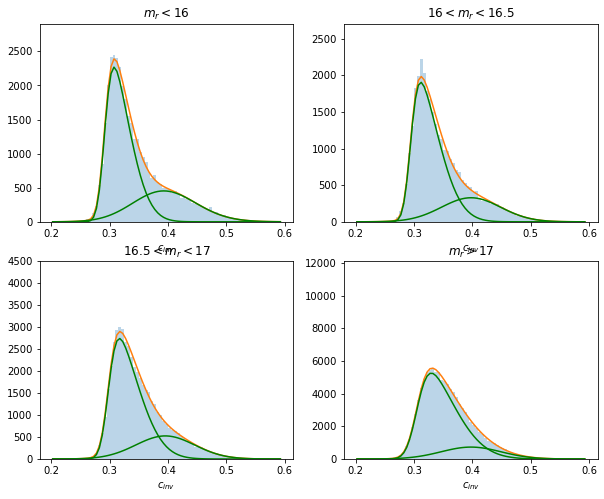

In [21]:
plt.figure(figsize=(10,8))

################################################################################
# Brightest galaxies
#-------------------------------------------------------------------------------
plt.subplot(221)

plt.hist(galaxies['conx1'][boolean_14p5_16 & color_boolean], 
         bins=cinv_bins, 
         alpha=0.3)

plt.plot(cinv_centers, skewNorms2(bestfit.x, cinv_centers))
plt.plot(cinv_centers, 
         bestfit.x[0]*skewnorm.pdf(cinv_centers, bestfit.x[3], loc=bestfit.x[1], scale=bestfit.x[2]), 
        'g')
plt.plot(cinv_centers,
         bestfit.x[4]*skewnorm.pdf(cinv_centers, bestfit.x[7], loc=bestfit.x[5], scale=bestfit.x[6]), 
        'g')

#plt.plot(cinv_centers,
#         bestfit.x[0]*norm.pdf(cinv_centers, loc=bestfit.x[1], scale=bestfit.x[2]), 
#         'r')
#plt.vlines(bestfit.x[1] + 2*bestfit.x[2], 0, 3000, colors='r', linestyle='dotted')

plt.ylim(ymax=2900)

plt.title('$m_r < 16$')
plt.xlabel('$c_{inv}$')
################################################################################


################################################################################
# 16 < mr < 16.5
#-------------------------------------------------------------------------------
plt.subplot(222)

plt.hist(galaxies['conx1'][boolean_16_16p5 & color_boolean], 
         bins=cinv_bins, 
         alpha=0.3)

plt.plot(cinv_centers, skewNorms2(bestfit_16_16p5.x, cinv_centers))
plt.plot(cinv_centers, 
         bestfit_16_16p5.x[0]*skewnorm.pdf(cinv_centers, 
                                           bestfit_16_16p5.x[3], 
                                           loc=bestfit_16_16p5.x[1], 
                                           scale=bestfit_16_16p5.x[2]), 
        'g')
plt.plot(cinv_centers,
         bestfit_16_16p5.x[4]*skewnorm.pdf(cinv_centers, 
                                           bestfit_16_16p5.x[7], 
                                           loc=bestfit_16_16p5.x[5], 
                                           scale=bestfit_16_16p5.x[6]), 
        'g')

#plt.vlines(bestfit_16_16p5.x[1] + 2*bestfit_16_16p5.x[2], 
#           0, 3000, colors='r', linestyle='dotted')

plt.ylim(ymax=2700)

plt.title('$16 < m_r < 16.5$')
plt.xlabel('$c_{inv}$')
################################################################################


################################################################################
# 16.5 < mr < 17
#-------------------------------------------------------------------------------
plt.subplot(223)

plt.hist(galaxies['conx1'][boolean_16p5_17 & color_boolean], 
         bins=cinv_bins, 
         alpha=0.3)

plt.plot(cinv_centers, skewNorms2(bestfit_16p5_17.x, cinv_centers))
plt.plot(cinv_centers, 
         bestfit_16p5_17.x[0]*skewnorm.pdf(cinv_centers, 
                                           bestfit_16p5_17.x[3], 
                                           loc=bestfit_16p5_17.x[1], 
                                           scale=bestfit_16p5_17.x[2]), 
        'g')
plt.plot(cinv_centers,
         bestfit_16p5_17.x[4]*skewnorm.pdf(cinv_centers, 
                                           bestfit_16p5_17.x[7], 
                                           loc=bestfit_16p5_17.x[5], 
                                           scale=bestfit_16p5_17.x[6]), 
        'g')

#plt.vlines(bestfit_16p5_17.x[1] + 2*bestfit_16p5_17.x[2], 
#           0, 4500, colors='r', linestyle='dotted')

plt.ylim(ymax=4500)

plt.title('$16.5 < m_r < 17$')
plt.xlabel('$c_{inv}$')
################################################################################


################################################################################
# Faintest galaxies
#-------------------------------------------------------------------------------
plt.subplot(224)

plt.hist(galaxies['conx1'][boolean_17_17p5 & color_boolean], 
         bins=cinv_bins, 
         alpha=0.3)

plt.plot(cinv_centers, skewNorms2(bestfit_faint.x, cinv_centers))
plt.plot(cinv_centers, 
         bestfit_faint.x[0]*skewnorm.pdf(cinv_centers, 
                                         bestfit_faint.x[3], 
                                         loc=bestfit_faint.x[1], 
                                         scale=bestfit_faint.x[2]), 
        'g')
plt.plot(cinv_centers,
         bestfit_faint.x[4]*skewnorm.pdf(cinv_centers, 
                                         bestfit_faint.x[7], 
                                         loc=bestfit_faint.x[5], 
                                         scale=bestfit_faint.x[6]), 
        'g')

#plt.vlines(bestfit_faint.x[1] + 2*bestfit_faint.x[2], 
#           0, 12100, colors='r', linestyle='dotted')

plt.ylim(ymax=12100)

plt.title('$m_r > 17$')
plt.xlabel('$c_{inv}$')
################################################################################


plt.tight_layout;

### $c_\text{inv}$ cut

We implement a cut on $c_\text{inv}$ to filter normal early-type galaxies from normal late-type galaxies which fall within the Park05 bounds defining normal early-type galaxies.

Instead of using fixed values (based on magnitude bins) as done in Park05, we will use the point of intersection between the two skew normal functions fit to the data.

In [22]:
from scipy.optimize import root_scalar

##### Bright galaxies

In [24]:
rootResults = root_scalar(skewNorms2_diff, 
                          args=bestfit.x, 
                          bracket=[0.3, 0.4], 
                          x0=(bestfit.x[1] + 2*bestfit.x[2]))

print(rootResults)

cinv_bright = rootResults.root

      converged: True
           flag: 'converged'
 function_calls: 12
     iterations: 11
           root: 0.3640146641574518


##### $16 < m_r < 16.5$

In [25]:
rootResults = root_scalar(skewNorms2_diff, 
                          args=bestfit_16_16p5.x, 
                          bracket=[0.3, 0.4], 
                          x0=(bestfit_16_16p5.x[1] + 2*bestfit_16_16p5.x[2]))

print(rootResults)

cinv_16_16p5 = rootResults.root

      converged: True
           flag: 'converged'
 function_calls: 10
     iterations: 9
           root: 0.37777868119971036


##### $16.5 < m_r < 17$

In [26]:
rootResults = root_scalar(skewNorms2_diff, 
                          args=bestfit_16p5_17.x, 
                          bracket=[0.3, 0.4], 
                          x0=(bestfit_16p5_17.x[1] + 2*bestfit_16p5_17.x[2]))

print(rootResults)

cinv_16p5_17 = rootResults.root

      converged: True
           flag: 'converged'
 function_calls: 9
     iterations: 8
           root: 0.3841281232833493


##### Faint galaxies

In [28]:
rootResults = root_scalar(skewNorms2_diff, 
                          args=bestfit_faint.x, 
                          bracket=[0.4, 0.5], 
                          x0=(bestfit_faint.x[1] + 2*bestfit_faint.x[2]))

print(rootResults)

cinv_faint = rootResults.root

      converged: True
           flag: 'converged'
 function_calls: 11
     iterations: 10
           root: 0.42609127084444526


## Morphological class
Based on the morphological classification of Park & Choi (2005)

#### Early-type

In [29]:
early_boolean1 = np.logical_and(galaxies['u_r_KIAS'] > 1, galaxies['cd'] > 0.3)

early_boolean2_14p5_16 = np.logical_and.reduce((galaxies['u_r_KIAS'] > 1, 
                                                galaxies['u_r_KIAS'] <= 2.6, 
                                                galaxies['cd'] > -0.28125*galaxies['u_r_KIAS'] + 0.58125))
early_boolean2_16_17 = np.logical_and.reduce((galaxies['u_r_KIAS'] > 1,
                                              galaxies['u_r_KIAS'] <= 2.65,
                                              galaxies['cd'] > -0.290909*galaxies['u_r_KIAS'] + 0.590909))
early_boolean2_17_17p5 = np.logical_and.reduce((galaxies['u_r_KIAS'] > 1,
                                                galaxies['u_r_KIAS'] <= 2.7,
                                                galaxies['cd'] > -0.28236*galaxies['u_r_KIAS'] + 0.582353))

early_boolean3_14p5_16 = np.logical_and(galaxies['u_r_KIAS'] > 2.60, galaxies['cd'] > -0.15)
early_boolean3_16_16p5 = np.logical_and(galaxies['u_r_KIAS'] > 2.65, galaxies['cd'] > -0.15)
early_boolean3_16p5_17 = np.logical_and(galaxies['u_r_KIAS'] > 2.65, galaxies['cd'] > -0.25)
early_boolean3_17_17p5 = np.logical_and(galaxies['u_r_KIAS'] > 2.70, galaxies['cd'] > -0.35)

early_boolean_14p5_16_area = np.logical_or.reduce((early_boolean1, 
                                                   early_boolean2_14p5_16, 
                                                   early_boolean3_14p5_16))
early_boolean_16_16p5_area = np.logical_or.reduce((early_boolean1, 
                                                   early_boolean2_16_17, 
                                                   early_boolean3_16_16p5))
early_boolean_16p5_17_area = np.logical_or.reduce((early_boolean1, 
                                                   early_boolean2_16_17, 
                                                   early_boolean3_16p5_17))
early_boolean_17_17p5_area = np.logical_or.reduce((early_boolean1, 
                                                   early_boolean2_17_17p5, 
                                                   early_boolean3_17_17p5))

# Require early-type galaxies to have inverse concentration indices smaller 
# than some value
early_boolean_14p5_16 = np.logical_and(early_boolean_14p5_16_area, 
                                       galaxies['conx1'] < cinv_bright)
early_boolean_16_16p5 = np.logical_and(early_boolean_16_16p5_area, 
                                       galaxies['conx1'] < cinv_16_16p5)
early_boolean_16p5_17 = np.logical_and(early_boolean_16p5_17_area, 
                                       galaxies['conx1'] < cinv_16p5_17)
early_boolean_17_17p5 = np.logical_and(early_boolean_17_17p5_area, 
                                       galaxies['conx1'] < cinv_faint)

# Galaxies that would normally have become late-types because of the above 
# restriction on cinv (conx1) are instead being classified as GV galaxies
gv_boolean_14p5_16 = np.logical_and(early_boolean_14p5_16_area, 
                                    galaxies['conx1'] >= cinv_bright)
gv_boolean_16_16p5 = np.logical_and(early_boolean_16_16p5_area, 
                                    galaxies['conx1'] >= cinv_16_16p5)
gv_boolean_16p5_17 = np.logical_and(early_boolean_16p5_17_area, 
                                    galaxies['conx1'] >= cinv_16p5_17)
gv_boolean_17_17p5 = np.logical_and(early_boolean_17_17p5_area, 
                                    galaxies['conx1'] >= cinv_faint)

'''
early_boolean1 = np.logical_and.reduce((galaxies['u_r_KIAS'] > 2.6, 
                                        galaxies['u_r_KIAS'] < 4, 
                                        galaxies['cd'] > -0.15))
early_boolean2 = np.logical_and.reduce((galaxies['u_r_KIAS'] > 1, 
                                        galaxies['u_r_KIAS'] < 4, 
                                        galaxies['cd'] > 0.3))
early_boolean3 = np.logical_and.reduce((#galaxies['u_r_KIAS'] > 1, 
                                        galaxies['u_r_KIAS'] > 2,
                                        galaxies['u_r_KIAS'] <= 2.6, 
                                        galaxies['cd'] > -0.28125*galaxies['u_r_KIAS'] + 0.58125))

#early_boolean = np.logical_or.reduce((early_boolean1, early_boolean2, early_boolean3))
early_boolean = np.logical_or.reduce((early_boolean1, early_boolean3))



# Include those RS galaxies with inverse concentration index >= 0.43 in the GV
green_boolean = np.logical_and(early_boolean, galaxies['conx1'] >= 0.43)

early_boolean = np.logical_and(early_boolean, galaxies['conx1'] < 0.43)



# Include those RS galaxies with u-r < 2.25 in the GV
early_boolean3b = np.logical_and.reduce((galaxies['u_r_KIAS'] > 1,
                                         galaxies['u_r_KIAS'] <= 2, 
                                         galaxies['cd'] > -0.28125*galaxies['u_r_KIAS'] + 0.58125))
green_boolean = np.logical_or.reduce((green_boolean, early_boolean2, early_boolean3b))
''';

#### Late type

Note that these galaxies contain those already assigned to the GV.

In [30]:
late_boolean_14p5_16 = np.logical_not(early_boolean_14p5_16)
late_boolean_16_16p5 = np.logical_not(early_boolean_16_16p5)
late_boolean_16p5_17 = np.logical_not(early_boolean_16p5_17)
late_boolean_17_17p5 = np.logical_not(early_boolean_17_17p5)

In [31]:
early_galaxies = vstack([galaxies[np.logical_and(boolean_14p5_16, early_boolean_14p5_16)], 
                         galaxies[np.logical_and(boolean_16_16p5, early_boolean_16_16p5)],
                         galaxies[np.logical_and(boolean_16p5_17, early_boolean_16p5_17)],
                         galaxies[np.logical_and(boolean_17_17p5, early_boolean_17_17p5)]])

late_galaxies_boolean = np.logical_or.reduce((np.logical_and(boolean_14p5_16, late_boolean_14p5_16),
                                              np.logical_and(boolean_16_16p5, late_boolean_16_16p5),
                                              np.logical_and(boolean_16p5_17, late_boolean_16p5_17),
                                              np.logical_and(boolean_17_17p5, late_boolean_17_17p5)))

In [32]:
gv_early_boolean = np.logical_or.reduce((np.logical_and(boolean_14p5_16, gv_boolean_14p5_16), 
                                         np.logical_and(boolean_16_16p5, gv_boolean_16_16p5), 
                                         np.logical_and(boolean_16p5_17, gv_boolean_16p5_17), 
                                         np.logical_and(boolean_17_17p5, gv_boolean_17_17p5)))

## Morphologial type
Based on the classification by Choi et al. (2010)

#### Normal late type

In [33]:
normal_late_boolean1 = np.logical_and.reduce((galaxies['u_r_KIAS'] > 1.8,
                                              galaxies['u_r_KIAS'] < 3.5,
                                              galaxies['cd'] > -0.7,
                                              galaxies['cd'] < 0.5))
normal_late_boolean2 = np.logical_and.reduce((galaxies['u_r_KIAS'] <= 1.8,
                                              galaxies['cd'] > -0.7,
                                              galaxies['cd'] < 1))

normal_late_boolean = np.logical_and(late_galaxies_boolean, 
                                     np.logical_or(normal_late_boolean1, normal_late_boolean2))

In [34]:
gv_normal_late_boolean = np.logical_and.reduce((normal_late_boolean, 
                                                galaxies['my_aimc'] <= 110, 
                                                np.logical_not(gv_early_boolean)))

bc_normal_late_boolean = np.logical_and.reduce((normal_late_boolean, 
                                                galaxies['my_aimc'] > 110, 
                                                np.logical_not(gv_early_boolean)))

#### Normal early type

In [35]:
normal_early_boolean = np.logical_and.reduce((early_galaxies['u_r_KIAS'] > 2.5,
                                              early_galaxies['u_r_KIAS'] < 3.5,
                                              early_galaxies['cd'] > -0.7, 
                                              early_galaxies['cd'] < 1))

#### Blue early type

In [36]:
blue_early_boolean = np.logical_and.reduce((early_galaxies['u_r_KIAS'] < 2.5,
                                            early_galaxies['cd'] > -0.7,
                                            early_galaxies['cd'] < 1))

In [37]:
normal_late_galaxies = galaxies[normal_late_boolean]
normal_early_galaxies = early_galaxies[normal_early_boolean]
blue_early_galaxies = early_galaxies[blue_early_boolean]

In [38]:
RS_galaxies = early_galaxies[normal_early_boolean]

GV_galaxies = vstack([blue_early_galaxies, 
                      galaxies[gv_early_boolean], 
                      galaxies[gv_normal_late_boolean]])

BC_galaxies = galaxies[bc_normal_late_boolean]

Check to make sure that there are no galaxies in more than one category.

In [39]:
################################################################################
# RS - GV overlap
#-------------------------------------------------------------------------------
rs_gv_overlap = 0

for i in range(len(GV_galaxies)):
    if GV_galaxies['index'][i] in RS_galaxies['index']:
        rs_gv_overlap += 1
    
print('Overlap between RS and GV:', rs_gv_overlap)
################################################################################

Overlap between RS and GV: 0


In [40]:
################################################################################
# RS - BC overlap
#-------------------------------------------------------------------------------
rs_bc_overlap = 0

for i in range(len(RS_galaxies)):
    if RS_galaxies['index'][i] in BC_galaxies['index']:
        rs_bc_overlap += 1
    
print('Overlap between RS and BC:', rs_bc_overlap)
################################################################################

Overlap between RS and BC: 0


In [41]:
################################################################################
# BC - GV overlap
#-------------------------------------------------------------------------------
bc_gv_overlap = 0

for i in range(len(GV_galaxies)):
    if GV_galaxies['index'][i] in BC_galaxies['index']:
        bc_gv_overlap += 1
    
print('Overlap between BC and GV:', bc_gv_overlap)
################################################################################

Overlap between BC and GV: 0


## Color distribution

In [42]:
ur_bins = np.linspace(0,4.5,100)
NUVr_bins = np.linspace(0,10,100)

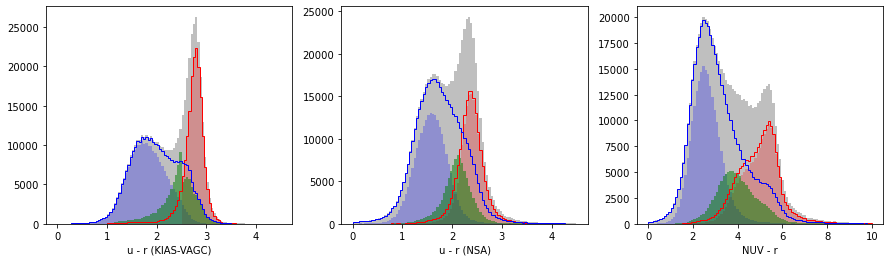

In [43]:
plt.figure(figsize=(15,4))

plt.subplot(131)

plt.hist(galaxies['u_r_KIAS'], bins=ur_bins, alpha=0.25, facecolor='k')

plt.hist(RS_galaxies['u_r_KIAS'], bins=ur_bins, alpha=0.25, facecolor='r')
plt.hist(BC_galaxies['u_r_KIAS'], bins=ur_bins, alpha=0.25, facecolor='b')
plt.hist(GV_galaxies['u_r_KIAS'], bins=ur_bins, alpha=0.5, facecolor='g')

plt.hist(early_galaxies['u_r_KIAS'], bins=ur_bins, histtype='step', edgecolor='r')
plt.hist(galaxies['u_r_KIAS'][late_galaxies_boolean], bins=ur_bins, histtype='step', edgecolor='b')

plt.xlabel('u - r (KIAS-VAGC)')




plt.subplot(132)

plt.hist(galaxies['u_r'], bins=ur_bins, alpha=0.25, facecolor='k')

plt.hist(RS_galaxies['u_r'], bins=ur_bins, alpha=0.25, facecolor='r')
plt.hist(BC_galaxies['u_r'], bins=ur_bins, alpha=0.25, facecolor='b')
plt.hist(GV_galaxies['u_r'], bins=ur_bins, alpha=0.5, facecolor='g')

plt.hist(early_galaxies['u_r'], bins=ur_bins, histtype='step', edgecolor='r')
plt.hist(galaxies['u_r'][late_galaxies_boolean], bins=ur_bins, histtype='step', edgecolor='b')

plt.xlabel('u - r (NSA)')




plt.subplot(133)

plt.hist(galaxies['NUV_r'], bins=NUVr_bins, alpha=0.25, facecolor='k')

plt.hist(RS_galaxies['NUV_r'], bins=NUVr_bins, alpha=0.25, facecolor='r')
plt.hist(BC_galaxies['NUV_r'], bins=NUVr_bins, alpha=0.25, facecolor='b')
plt.hist(GV_galaxies['NUV_r'], bins=NUVr_bins, alpha=0.5, facecolor='g')

plt.hist(early_galaxies['NUV_r'], bins=NUVr_bins, histtype='step', edgecolor='r')
plt.hist(galaxies['NUV_r'][late_galaxies_boolean], bins=NUVr_bins, histtype='step', edgecolor='b')

plt.xlabel('NUV - r');

There is a strange discontinuity in the GV population at $u - r = 2.5$.  It is most apparent in the KIAS-VAGC $u-r$ distribution, not the $u-r$ in the NSA.  This corresponds to a sharp cut in the RS at $u-r = 2.5$ as well, and is a result of the criteria separating the blue early types from the normal early types.

## CMDs

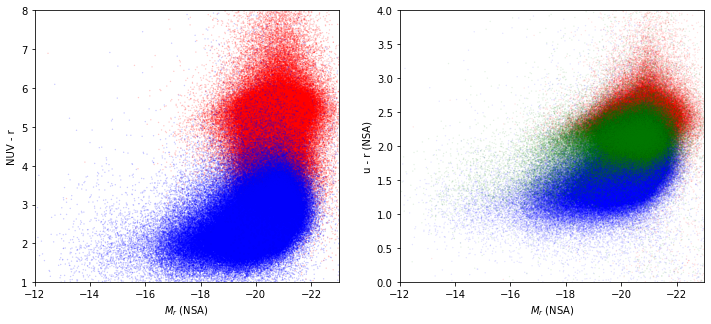

In [44]:
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.scatter(RS_galaxies['ELPETRO_ABSMAG'][:,4], RS_galaxies['NUV_r'], s=2, c='r', alpha=0.2, 
            edgecolors='none')
plt.scatter(BC_galaxies['ELPETRO_ABSMAG'][:,4], BC_galaxies['NUV_r'], s=2, c='b', alpha=0.2, 
            edgecolors='none')
#plt.scatter(GV_galaxies['rabsmag'], GV_galaxies['NUV_r'], s=2, c='g', alpha=0.2,
#            edgecolors='none')
plt.xlabel('$M_r$ (NSA)')
plt.ylabel('NUV - r')
plt.axis([-12, -23, 1, 8])

plt.subplot(122)
plt.scatter(RS_galaxies['ELPETRO_ABSMAG'][:,4], RS_galaxies['u_r'], s=2, c='r', alpha=0.1, 
            edgecolors='none')
plt.scatter(BC_galaxies['ELPETRO_ABSMAG'][:,4], BC_galaxies['u_r'], s=2, c='b', alpha=0.1, 
            edgecolors='none')
plt.scatter(GV_galaxies['ELPETRO_ABSMAG'][:,4], GV_galaxies['u_r'], s=2, c='g', alpha=0.1,
            edgecolors='none')
plt.xlabel('$M_r$ (NSA)')
plt.ylabel('u - r (NSA)')
plt.axis([-12, -23, 0, 4]);

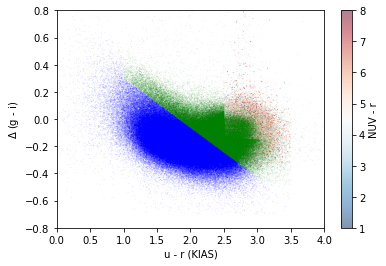

In [45]:
plt.figure()

plt.scatter(RS_galaxies['u_r_KIAS'], RS_galaxies['cd'], s=1, c=RS_galaxies['NUV_r'], 
            cmap=cm.RdBu_r, edgecolors='none', alpha=0.5, label='Red sequence')
cbar = plt.colorbar()
plt.clim(1,8)
cbar.ax.set_ylabel('NUV - r')

plt.scatter(BC_galaxies['u_r_KIAS'], BC_galaxies['cd'], s=1, c='b', alpha=0.1, edgecolors='none', 
            label='Blue cloud')

plt.scatter(GV_galaxies['u_r_KIAS'], GV_galaxies['cd'], s=1, c='g', alpha=0.1, edgecolors='none', 
            label='Green valley')

plt.xlabel('u - r (KIAS)')
plt.ylabel('$\Delta$ (g - i)')

#plt.legend()

plt.axis([0, 4, -0.8, 0.8]);

# Testing my function of the classification

In [122]:
from CMD_classification import CMD_class

In [123]:
galaxies['CMD_class'] = CMD_class(galaxies['u_r'], galaxies['cd'], galaxies['conx1'], galaxies['prmag'])

### Separate by CMD class

In [124]:
BC = galaxies[galaxies['CMD_class'] == 1]

GV = galaxies[galaxies['CMD_class'] == 2]

RS = galaxies[galaxies['CMD_class'] == 3]

### Color distribution

<IPython.core.display.Javascript object>


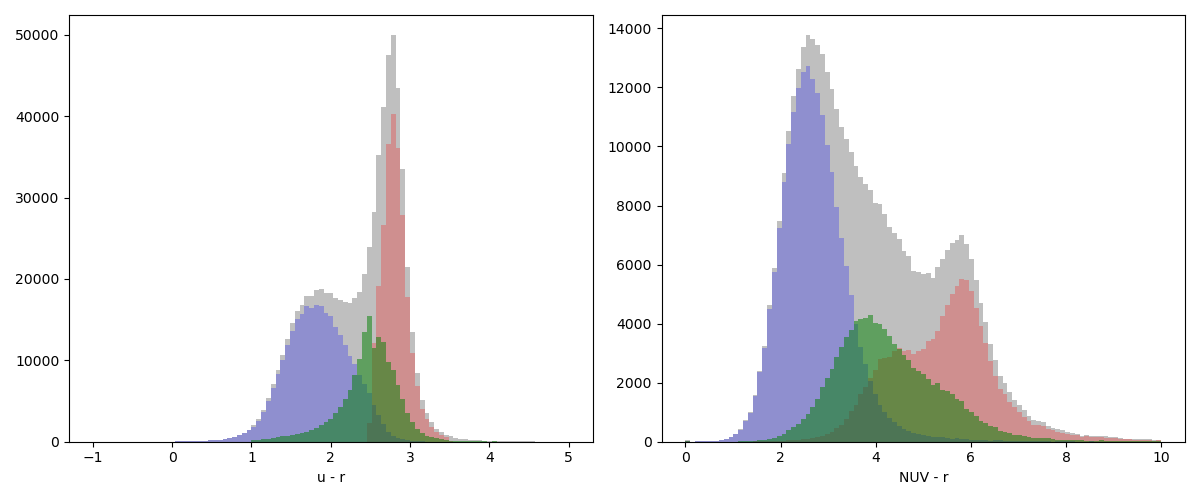

In [126]:
plt.figure(figsize=(12,5))


x_range = np.linspace(-1,5,100)

plt.subplot(121)
plt.hist(galaxies['u_r'], bins=x_range, alpha=0.25, facecolor='k')
plt.hist(RS['u_r'], bins=x_range, alpha=0.25, facecolor='r')
plt.hist(BC['u_r'], bins=x_range, alpha=0.25, facecolor='b')
plt.hist(GV['u_r'], bins=x_range, alpha=0.5, facecolor='g')

plt.xlabel('u - r')



x_range_NUVr = np.linspace(0,10,100)

plt.subplot(122)
plt.hist(galaxies['NUV_r'], bins=x_range_NUVr, alpha=0.25, facecolor='k')
plt.hist(RS['NUV_r'], bins=x_range_NUVr, alpha=0.25, facecolor='r')
plt.hist(BC['NUV_r'], bins=x_range_NUVr, alpha=0.25, facecolor='b')
plt.hist(GV['NUV_r'], bins=x_range_NUVr, alpha=0.5, facecolor='g')

plt.xlabel('NUV - r')


plt.tight_layout();

### CMDs

<IPython.core.display.Javascript object>


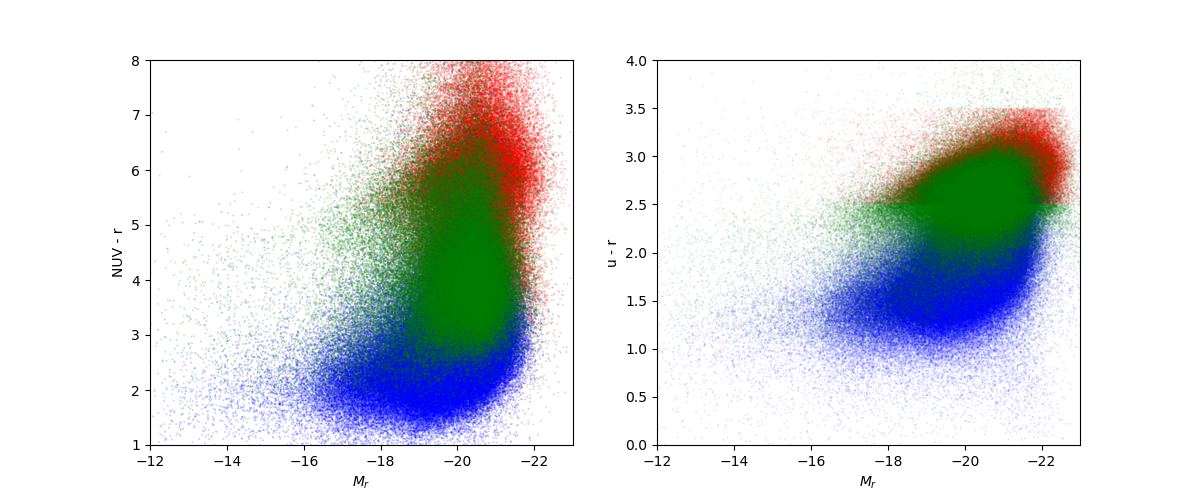

In [131]:
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.scatter(RS['rabsmag'], RS['NUV_r'], s=2, c='r', alpha=0.2, edgecolors='none')
plt.scatter(BC['rabsmag'], BC['NUV_r'], s=2, c='b', alpha=0.2, edgecolors='none')
plt.scatter(GV['rabsmag'], GV['NUV_r'], s=2, c='g', alpha=0.2,edgecolors='none')

plt.xlabel('$M_r$')
plt.ylabel('NUV - r')

plt.axis([-12, -23, 1, 8])




plt.subplot(122)
plt.scatter(RS['rabsmag'], RS['u_r'], s=2, c='r', alpha=0.1, edgecolors='none')
plt.scatter(BC['rabsmag'], BC['u_r'], s=2, c='b', alpha=0.1, edgecolors='none')
plt.scatter(GV['rabsmag'], GV['u_r'], s=2, c='g', alpha=0.1, edgecolors='none')

plt.xlabel('$M_r$')
plt.ylabel('u - r')

plt.axis([-12, -23, 0, 4]);

<IPython.core.display.Javascript object>


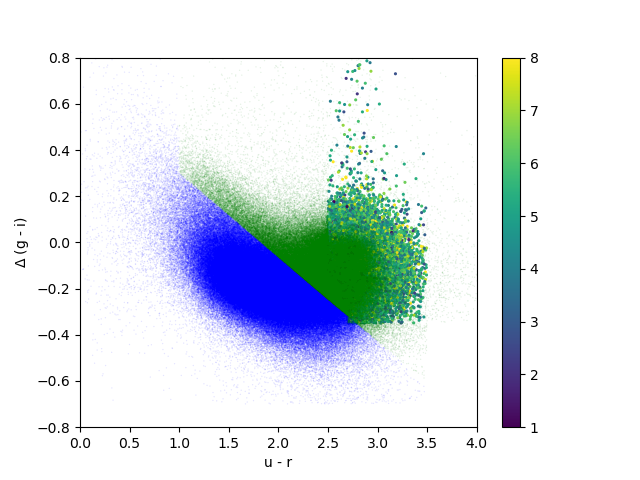

In [132]:
plt.figure()

plt.scatter(RS['u_r'], RS['cd'], s=5, c=RS['NUV_r'], edgecolors='none')
cbar = plt.colorbar()
cbar.ax.set_ylabel('NUV - r')
plt.clim(1,8)

plt.scatter(BC['u_r'], BC['cd'], s=1, c='b', alpha=0.1, edgecolors='none')

plt.scatter(GV['u_r'], GV['cd'], s=1, c='g', alpha=0.1, edgecolors='none')

plt.xlabel('u - r')
plt.ylabel('$\Delta$ (g - i)')

plt.axis([0, 4, -0.8, 0.8]);

### Stellar mass distribution

<IPython.core.display.Javascript object>


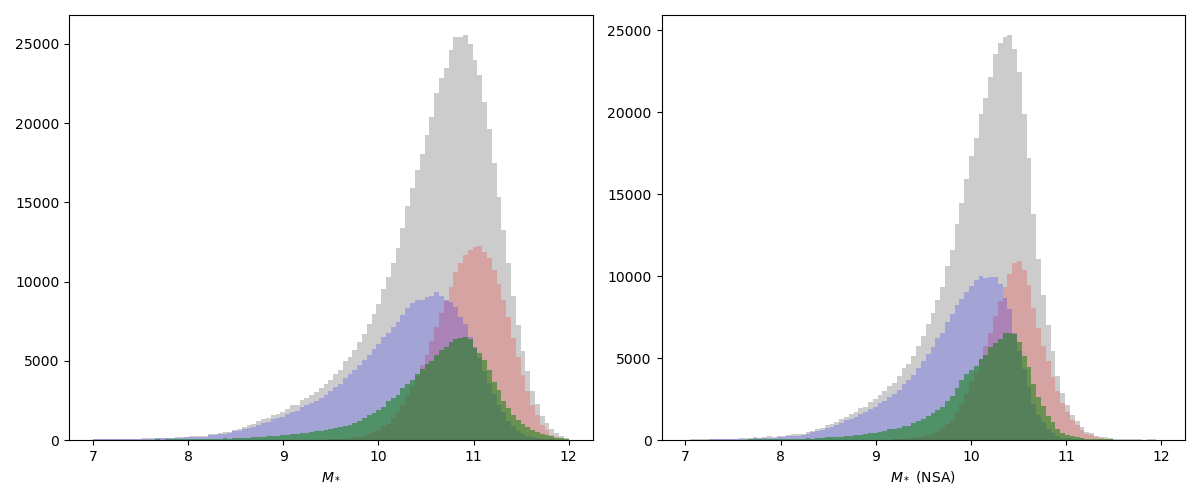

/Users/kellydouglass/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log10
/Users/kellydouglass/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log10
/Users/kellydouglass/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/Users/kellydouglass/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10


In [134]:
plt.figure(figsize=(12,5))

x_range_Mstar = np.linspace(7,12,100)


plt.subplot(121)
plt.hist(galaxies['Mstar'], bins=x_range_Mstar, alpha=0.2, facecolor='k')
plt.hist(RS['Mstar'], bins=x_range_Mstar, alpha=0.2, facecolor='r')
plt.hist(BC['Mstar'], bins=x_range_Mstar, alpha=0.2, facecolor='b')
plt.hist(GV['Mstar'], bins=x_range_Mstar, alpha=0.5, facecolor='g')

plt.xlabel('$M_*$')



plt.subplot(122)
plt.hist(np.log10(galaxies['Mstar_NSA']), bins=x_range_Mstar, alpha=0.2, facecolor='k')
plt.hist(np.log10(RS['Mstar_NSA']), bins=x_range_Mstar, alpha=0.2, facecolor='r')
plt.hist(np.log10(BC['Mstar_NSA']), bins=x_range_Mstar, alpha=0.2, facecolor='b')
plt.hist(np.log10(GV['Mstar_NSA']), bins=x_range_Mstar, alpha=0.5, facecolor='g')

plt.xlabel('$M_*$ (NSA)')

plt.tight_layout();

### Star formation distributions

<IPython.core.display.Javascript object>


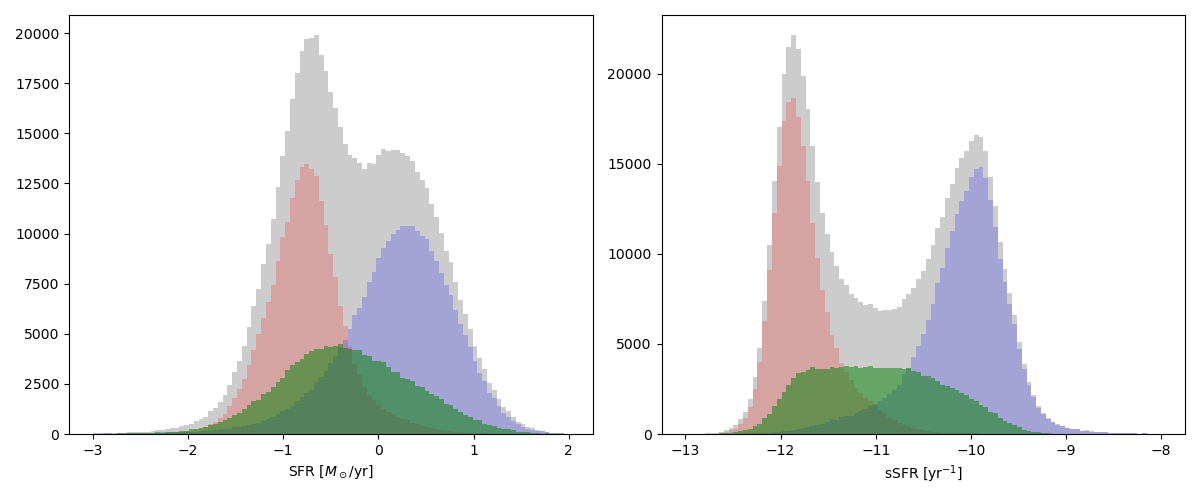

In [135]:
plt.figure(figsize=(12,5))

x_range_SFR = np.linspace(-3,2,100)

plt.subplot(121)
plt.hist(galaxies['SFR'], bins=x_range_SFR, alpha=0.2, facecolor='k')
plt.hist(RS['SFR'], bins=x_range_SFR, alpha=0.2, facecolor='r')
plt.hist(BC['SFR'], bins=x_range_SFR, alpha=0.2, facecolor='b')
plt.hist(GV['SFR'], bins=x_range_SFR, alpha=0.5, facecolor='g')

plt.xlabel('SFR [$M_\odot$/yr]')



x_range_sSFR = np.linspace(-13,-8,100)

plt.subplot(122)
plt.hist(galaxies['sSFR'], bins=x_range_sSFR, alpha=0.2, facecolor='k')
plt.hist(RS['sSFR'], bins=x_range_sSFR, alpha=0.2, facecolor='r')
plt.hist(BC['sSFR'], bins=x_range_sSFR, alpha=0.2, facecolor='b')
plt.hist(GV['sSFR'], bins=x_range_sSFR, alpha=0.5, facecolor='g')

plt.xlabel('sSFR [yr$^{-1}$]')


plt.tight_layout();

### Gas-phase abundance distributions

<IPython.core.display.Javascript object>


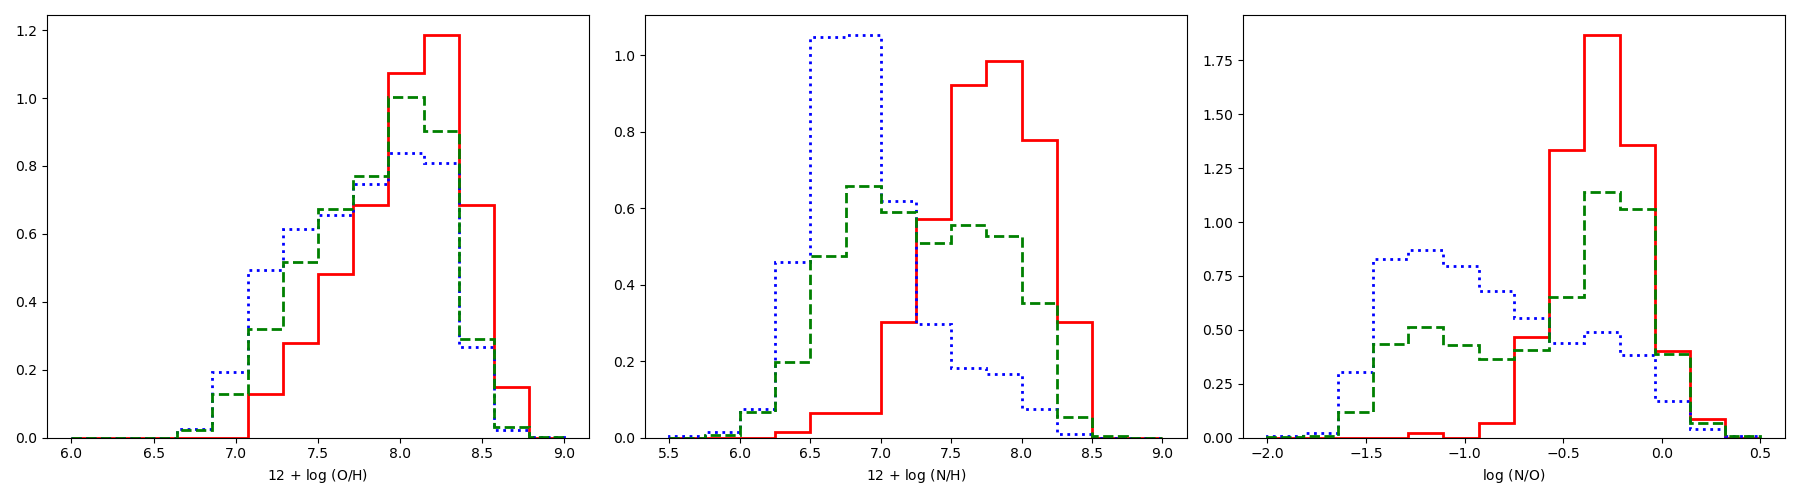

/Users/kellydouglass/opt/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)
/Users/kellydouglass/opt/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)
/Users/kellydouglass/opt/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)
/Users/kellydouglass/opt/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)
/Users/kellydouglass/opt/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)
/Users/kellydouglass/opt/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:102

In [136]:
plt.figure(figsize=(18,5))

x_range_OH = np.linspace(6,9,15)

plt.subplot(131)
plt.hist(RS['Z12logOH'][RS['t3'] < 3], bins=x_range_OH, density=True, edgecolor='r', linewidth=2, histtype='step')
plt.hist(BC['Z12logOH'][BC['t3'] < 3], bins=x_range_OH, density=True, edgecolor='b', linewidth=2, histtype='step', linestyle=':')
plt.hist(GV['Z12logOH'][GV['t3'] < 3], bins=x_range_OH, density=True, edgecolor='g', linewidth=2, histtype='step', linestyle='--')

plt.xlabel('12 + $\log$ (O/H)')



x_range_NH = np.linspace(5.5,9,15)

plt.subplot(132)
plt.hist(RS['N12logNH'][RS['t3'] < 3], bins=x_range_NH, density=True, histtype='step', edgecolor='r', linewidth=2)
plt.hist(BC['N12logNH'][BC['t3'] < 3], bins=x_range_NH, density=True, histtype='step', edgecolor='b', linewidth=2, linestyle=':')
plt.hist(GV['N12logNH'][GV['t3'] < 3], bins=x_range_NH, density=True, histtype='step', edgecolor='g', linewidth=2, linestyle='--')

plt.xlabel('12 + $\log$ (N/H)')



x_range_NO = np.linspace(-2,0.5,15)

plt.subplot(133)
plt.hist(RS['logNO'][RS['t3'] < 3], bins=x_range_NO, density=True, histtype='step', edgecolor='r', linewidth=2)
plt.hist(BC['logNO'][BC['t3'] < 3], bins=x_range_NO, density=True, histtype='step', edgecolor='b', linewidth=2, linestyle=':')
plt.hist(GV['logNO'][GV['t3'] < 3], bins=x_range_NO, density=True, histtype='step', edgecolor='g', linewidth=2, linestyle='--')

plt.xlabel('$\log$ (N/O)')


plt.tight_layout();

### Color-color diagram

To compare against Fig. 7 from Schawinski et al. (2014)

<IPython.core.display.Javascript object>


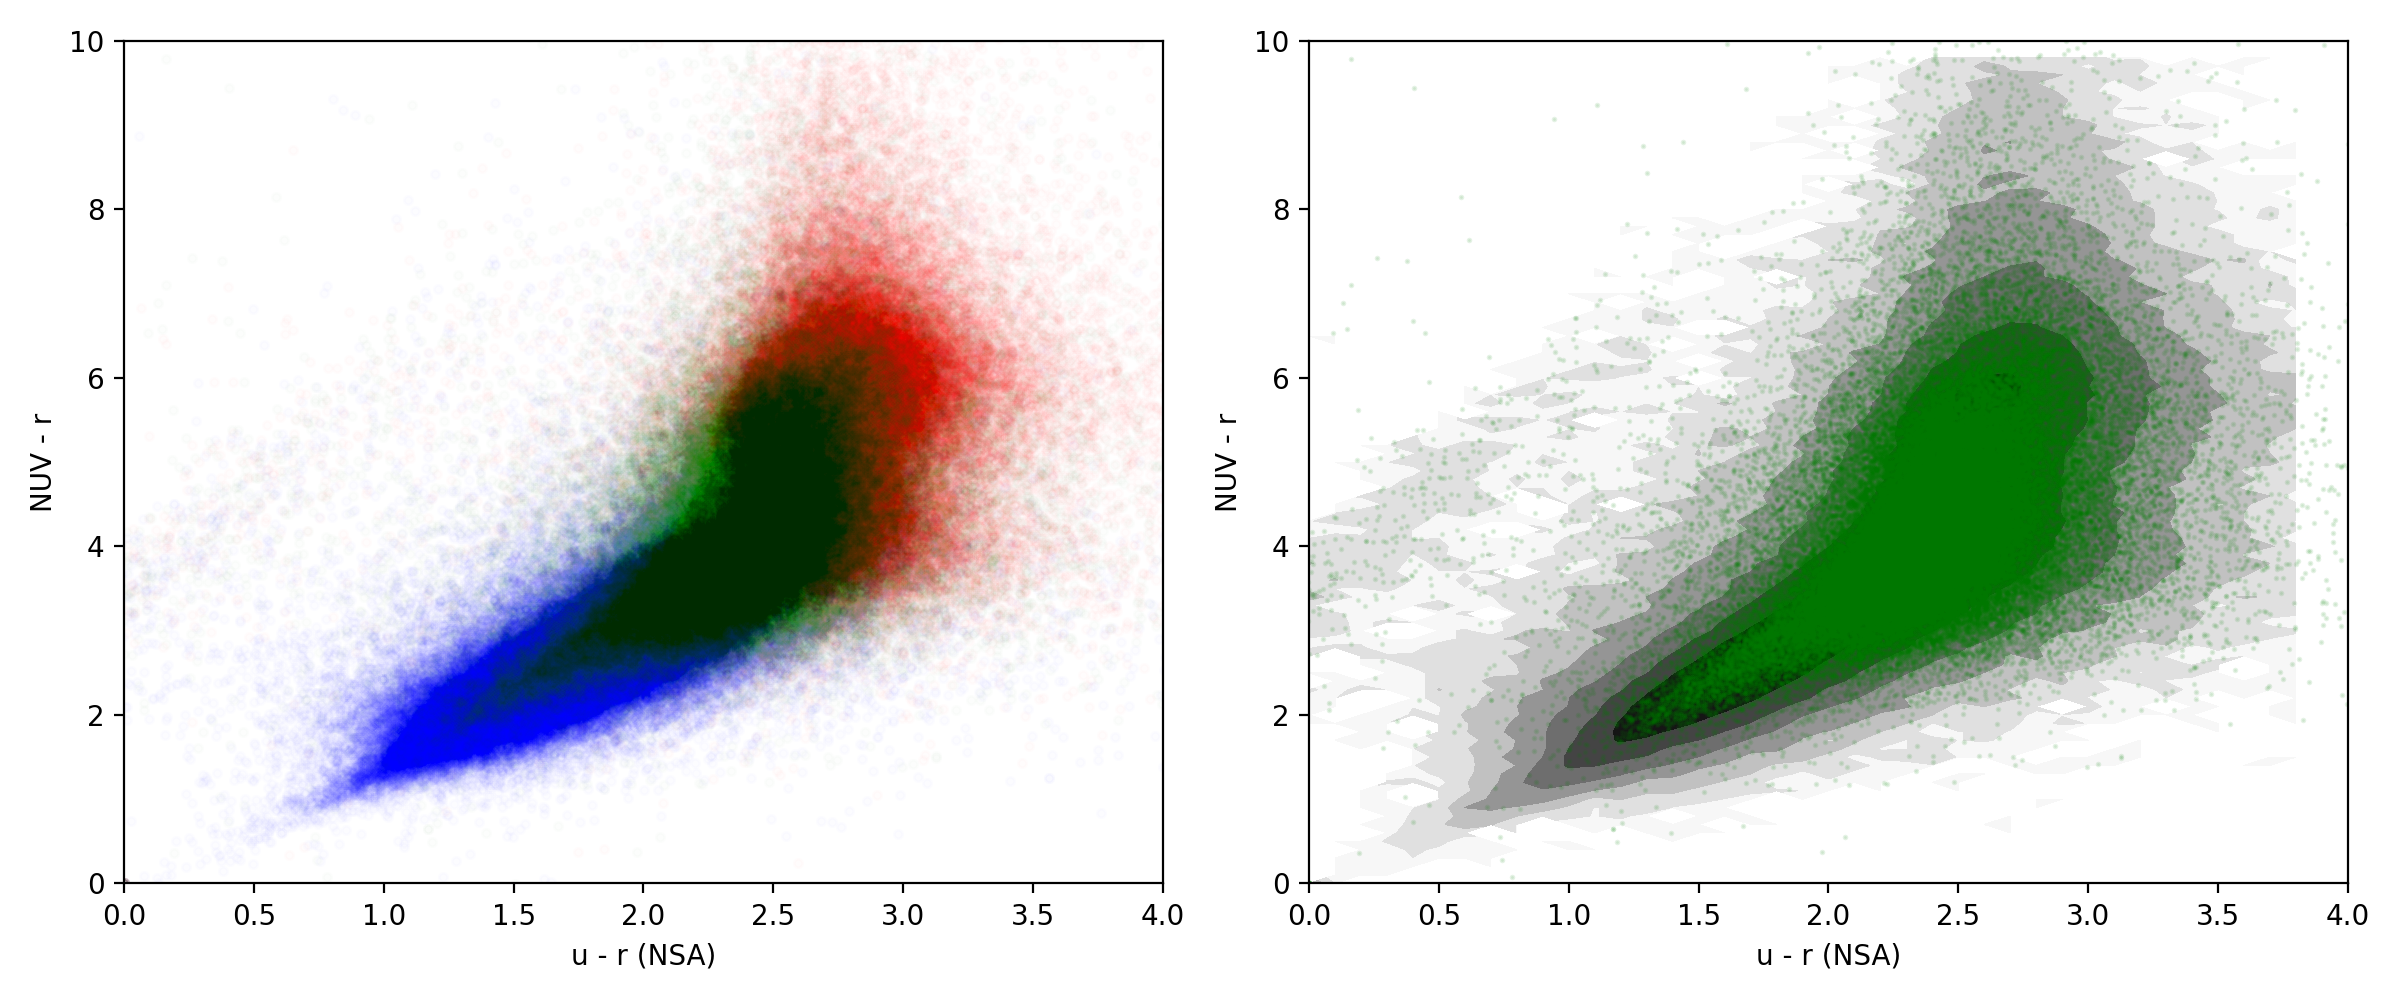

/Users/kellydouglass/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log10


In [169]:
plt.figure(figsize=(12,5))


plt.subplot(121)

plt.plot(RS['u_r_NSA'], RS['NUV_r'], 'r.', alpha=0.01)
plt.plot(BC['u_r_NSA'], BC['NUV_r'], 'b.', alpha=0.01)
plt.plot(GV['u_r_NSA'], GV['NUV_r'], 'g.', alpha=0.01)

plt.xlabel('u - r (NSA)')
plt.ylabel('NUV - r')

plt.axis([0, 4, 0, 10])



plt.subplot(122)

# Bin data for contour plot
A_N, Medges, Cedges = np.histogram2d(galaxies['u_r_NSA'], galaxies['NUV_r'], 
                                     bins=(np.arange(0,4,0.1),np.arange(0,10,0.1)))
Mmesh,Cmesh = np.meshgrid(Medges[:-1], Cedges[:-1], indexing='ij')

plt.contourf(Mmesh, Cmesh, np.log10(A_N), cmap=cm.get_cmap('Greys'))
plt.scatter(GV['u_r_NSA'], GV['NUV_r'], c='g', s=1, alpha=0.1)

plt.xlabel('u - r (NSA)')
plt.ylabel('NUV - r')

plt.axis([0, 4, 0, 10])

plt.tight_layout();

Still fairly certain that the bluer population of galaxies in the RS should really be part of the GV.

I also think that there is a chunk of galaxies in the GV that should really be in the BC.  I believe that this is coming from defining the aimc from (1, 0.3) in the (color, color gradient) space.

### Color-mass diagrams

<IPython.core.display.Javascript object>


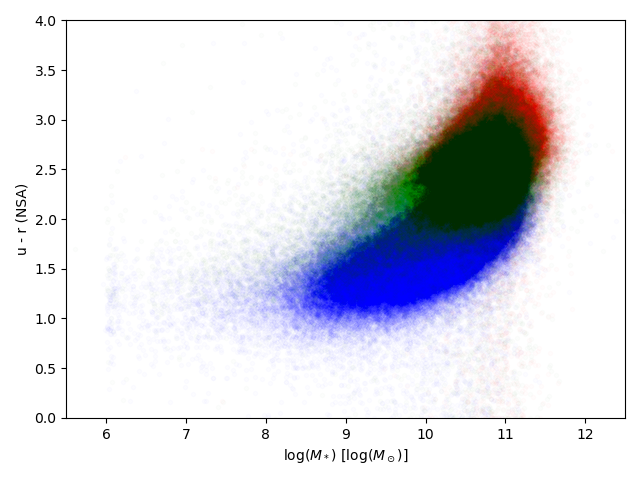

In [149]:
plt.figure()

plt.plot(RS['Mstar'], RS['u_r_NSA'], 'r.', alpha=0.01)
plt.plot(BC['Mstar'], BC['u_r_NSA'], 'b.', alpha=0.01)
plt.plot(GV['Mstar'], GV['u_r_NSA'], 'g.', alpha=0.01)

plt.xlabel('log($M_*$) [log($M_\odot$)]')
plt.ylabel('u - r (NSA)')

plt.axis([5.5, 12.5, 0, 4])

plt.tight_layout();

### (s)SFR - mass diagrams

<IPython.core.display.Javascript object>


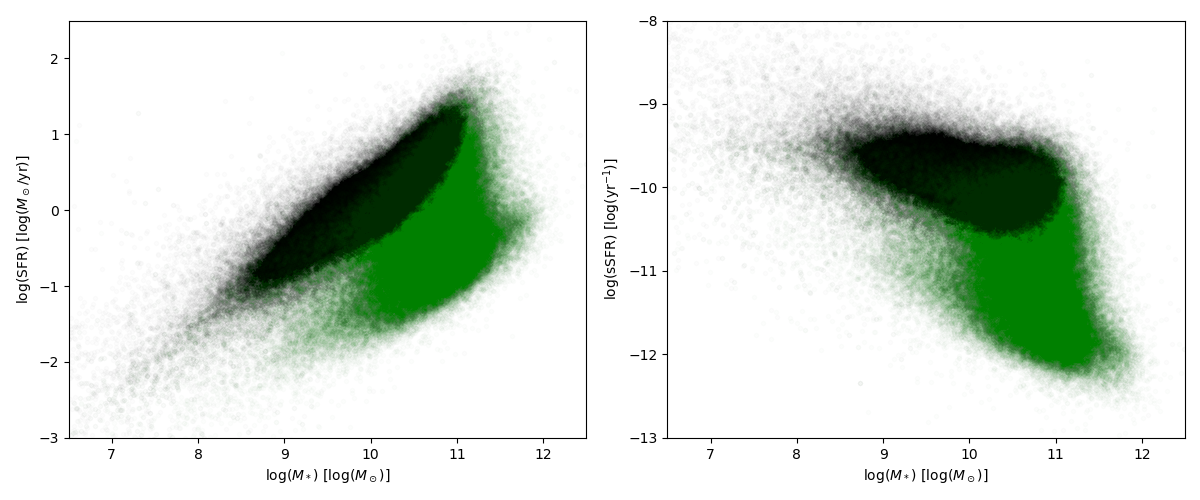

In [161]:
SF_boolean = galaxies['BPTclass'] == 1

plt.figure(figsize=(12,5))



plt.subplot(121)

plt.plot(galaxies['Mstar'][SF_boolean], galaxies['SFR'][SF_boolean], 'k.', alpha=0.01)
#plt.plot(RS['Mstar'], RS['SFR'], 'r.', alpha=0.01)
#plt.plot(BC['Mstar'], BC['SFR'], 'b.', alpha=0.01)
plt.plot(GV['Mstar'], GV['SFR'], 'g.', alpha=0.01)

plt.xlabel('log($M_*$) [log($M_\odot$)]')
plt.ylabel('log(SFR) [log($M_\odot$/yr)]')

plt.axis([6.5, 12.5, -3, 2.5])


plt.subplot(122)

plt.plot(galaxies['Mstar'][SF_boolean], galaxies['sSFR'][SF_boolean], 'k.', alpha=0.01)
#plt.plot(RS['Mstar'], RS['sSFR'], 'r.', alpha=0.01)
#plt.plot(BC['Mstar'], BC['sSFR'], 'b.', alpha=0.01)
plt.plot(GV['Mstar'], GV['sSFR'], 'g.', alpha=0.01)

plt.xlabel('log($M_*$) [log($M_\odot$)]')
plt.ylabel('log(sSFR) [log(yr$^{-1}$)]')

plt.axis([6.5, 12.5, -13, -8])

plt.tight_layout();

These are substantially different than what is found in Schawinski et al. (2014).  They find that GV galaxies always have lower (s)SFRs than star-forming galaxies (according to the BPT diagram).  We find that GV galaxies are both below and within the main star-forming galaxy sequence.